In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import ast
import matplotlib.patches as mpatches
from scipy.stats import t
from itertools import combinations
from math import factorial
from scipy.stats import bootstrap

# Generate performance plots between all trained models over the grid of correlation thresholds per time point (III+14 and C-1)
## Precision recall AUC is used as performance measurment. However MCC and ROC-AUC are also accessable as performance measurments. 

In [2]:
def stripper(x, length):
    dummy = []
    for i in x.strip().strip('[]').split():
        single = i.strip('\n')
        if single.isspace():
            continue
        if len(single) == 0:
            continue
        try:
            temp = float(single)
            dummy.append(temp)
        except:
            print(f"Warning: Couldn't convert {single} to float.")
    if len(dummy) != length:
        print(f"Warning: Only {len(dummy)} values were converted.")
    return dummy



def calc_mean(x):
    """Calculate mean performance value over all correlation thresholds per model
        for ncv

    Parameters:
    -----------

    x: dictionary of floats

    Reuturns:
    ---------

    x: dictionary containing mean performance value per model

    """
    combis = ['RRP', 'RPP', 'RPR', 'RRR']
    columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'RF_singleTime', 'RLR_singleTime', 'SVM_singleTime']
    for dataset in ['whole', 'selective']:
        for time in ['III14', "C-1"]:
                for col in columns:
                     #print(np.mean(x[dataset][f'{time}_ncv_mean'][col]))
                     x[dataset][f'{time}_ncv'].loc['mean_thresholds',col] = np.mean(x[dataset][f'{time}_ncv_mean'][col])
                     #print(x[dataset][f'{time}_ncv'][col])
    #print(x)
    return x




def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes two-sided paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = 2 * t.sf(np.abs(t_stat), df)  # two-sided t-test
    return t_stat, p_val

In [3]:
# Dataholder for precision_recall_auc performance measurment 
combis = ['RRP', 'RPP', 'RPR', 'RRR']
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
methods = ['RF', 'RLR', 'SVM', 'multitaskSVM']
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'RF_singleTime', 'RLR_singleTime', 'SVM_singleTime']
#columns = ['RF_multiTime', 'RLR_multiTime', 'SVM_multiTime', 'RRP_multiTime', 'RPP_multiTime', 'RPR_muliTime', 'RRR_multiTime']
times = ['III14', 'C-1']
results = {
    'whole': {
        'III14_test': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        
    },
    'selective': {
        'III14_test': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        
    },
}
result_dir="/Users/schmidtj/MalariaVaccineEfficacyPrediction/results"
#print(results)
for threshold in thresholds:
    for method in methods:
        maindir = f"{result_dir}/threshold{threshold}/{method}"
        for dataset in ['whole', 'selective']:
                for analysis_time in ['multiTime', 'singleTime']:
                    if method == 'multitaskSVM' and analysis_time =='multiTime':
                        for combination in combis:
                            ana_dir = f"{maindir}/{dataset}/{combination}/{analysis_time}/RNCV"
                            #print(ana_dir)
                            fn = os.path.join(ana_dir, "collected_key_results.tsv")
                            try:
                                temp =  pd.read_csv(fn, sep='\t', index_col=0)
                                #print(temp)
                            except:
                                print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}, combination={combination}, analysis_time={analysis_time}.")
                                continue
                            for time in times:
                                
                                results[dataset][f'{time}_ncv'].loc[threshold, combination] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['ncv_precision_recall_auc'].values[0], length=10)

                                results[dataset][f'{time}_test'].loc[threshold, combination] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['test_precision_recall_auc'].values[0], length=50)

                                results[dataset][f'{time}_ncv_mean'].loc[threshold, combination] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['mean_ncv_precision_recall_auc'].values[0]

                                results[dataset][f'{time}_test_mean'].loc[threshold, combination] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['mean_test_precision_recall_auc'].values[0]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['test_precision_recall_auc'].values[0], length=50),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_test_conf'].loc[threshold, combination] = [ci_l, ci_u]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['ncv_precision_recall_auc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_ncv_conf'].loc[threshold, combination] = [ci_l, ci_u]

                    else:
                        if analysis_time == 'singleTime':
                            ana_dir = f"{maindir}/{dataset}/{analysis_time}/RNCV"
                        
                            fn = os.path.join(ana_dir, "collected_key_results.tsv")
                            try:
                                temp =  pd.read_csv(fn, sep='\t', index_col=0)
                                
                            except:
                                print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}, analysis_time={analysis_time}.")
                                continue
                            for time in times:
                                
                                results[dataset][f'{time}_ncv'].loc[threshold, f'{method}_{analysis_time}'] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['ncv_precision_recall_auc'].values[0], length=10)
                                
                                results[dataset][f'{time}_test'].loc[threshold, f'{method}_{analysis_time}'] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['test_precision_recall_auc'].values[0], length=50)

                                results[dataset][f'{time}_ncv_mean'].loc[threshold, f'{method}_{analysis_time}'] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['mean_ncv_precision_recall_auc'].values[0]

                                results[dataset][f'{time}_test_mean'].loc[threshold,f'{method}_{analysis_time}'] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['mean_test_precision_recall_auc'].values[0]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['test_precision_recall_auc'].values[0], length=50),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_test_conf'].loc[threshold, f'{method}_{analysis_time}'] = [ci_l, ci_u]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['ncv_precision_recall_auc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_ncv_conf'].loc[threshold, f'{method}_{analysis_time}'] = [ci_l, ci_u]
                            
                            # index method muss noch die analysis zeit mit dazu bekommen!
                        else:
                        
                            ana_dir = f"{maindir}/{dataset}/{analysis_time}/RNCV"
                            fn = os.path.join(ana_dir, "collected_key_results.tsv")
                            try:
                                temp =  pd.read_csv(fn, sep='\t', index_col=0)
                            except:
                                print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}, analysis_time={analysis_time}.")
                                continue
                            for time in times:

                                results[dataset][f'{time}_ncv'].loc[threshold, method] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['ncv_precision_recall_auc'].values[0], length=10)

                                results[dataset][f'{time}_test'].loc[threshold, method] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['test_precision_recall_auc'].values[0], length=50)

                                results[dataset][f'{time}_ncv_mean'].loc[threshold, method] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['mean_ncv_precision_recall_auc'].values[0]

                                results[dataset][f'{time}_test_mean'].loc[threshold, method] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['mean_test_precision_recall_auc'].values[0]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['test_precision_recall_auc'].values[0], length=50),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_test_conf'].loc[threshold, method] = [ci_l, ci_u]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['ncv_precision_recall_auc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_ncv_conf'].loc[threshold, method] = [ci_l, ci_u]
                            
                                


No results found for threshold=0.1, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.1, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.2, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.2, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.3, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.3, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.4, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.4, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.5, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.5, method=multitaskSVM, dataset=selective, analysis_time=singleTime.


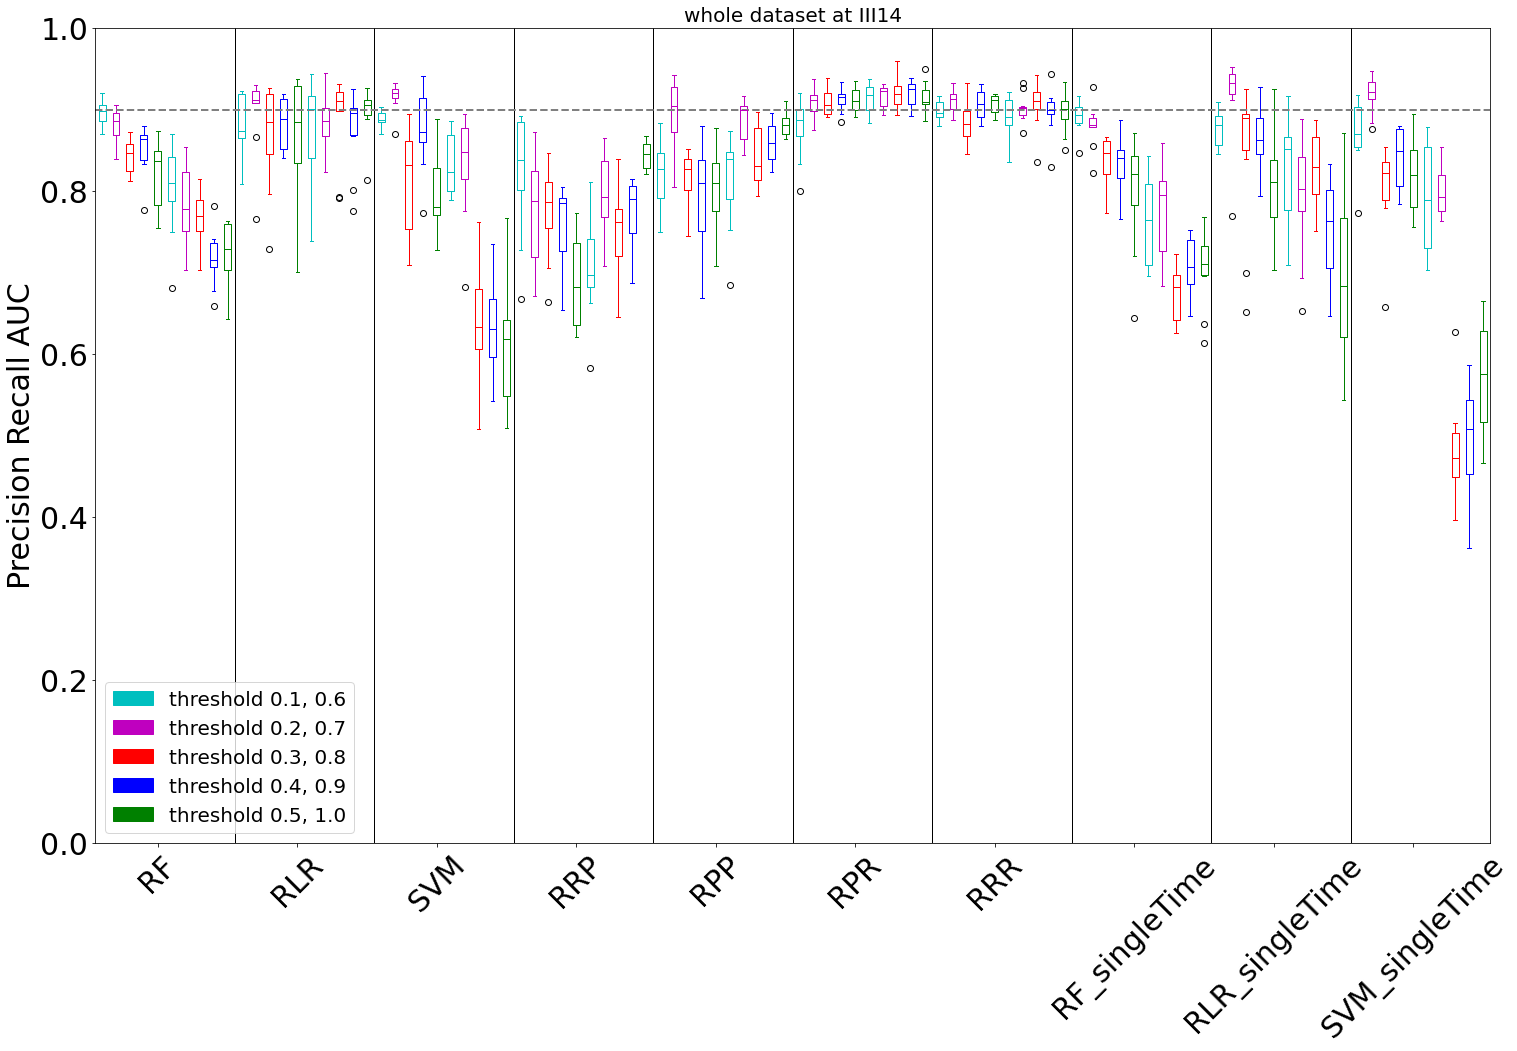

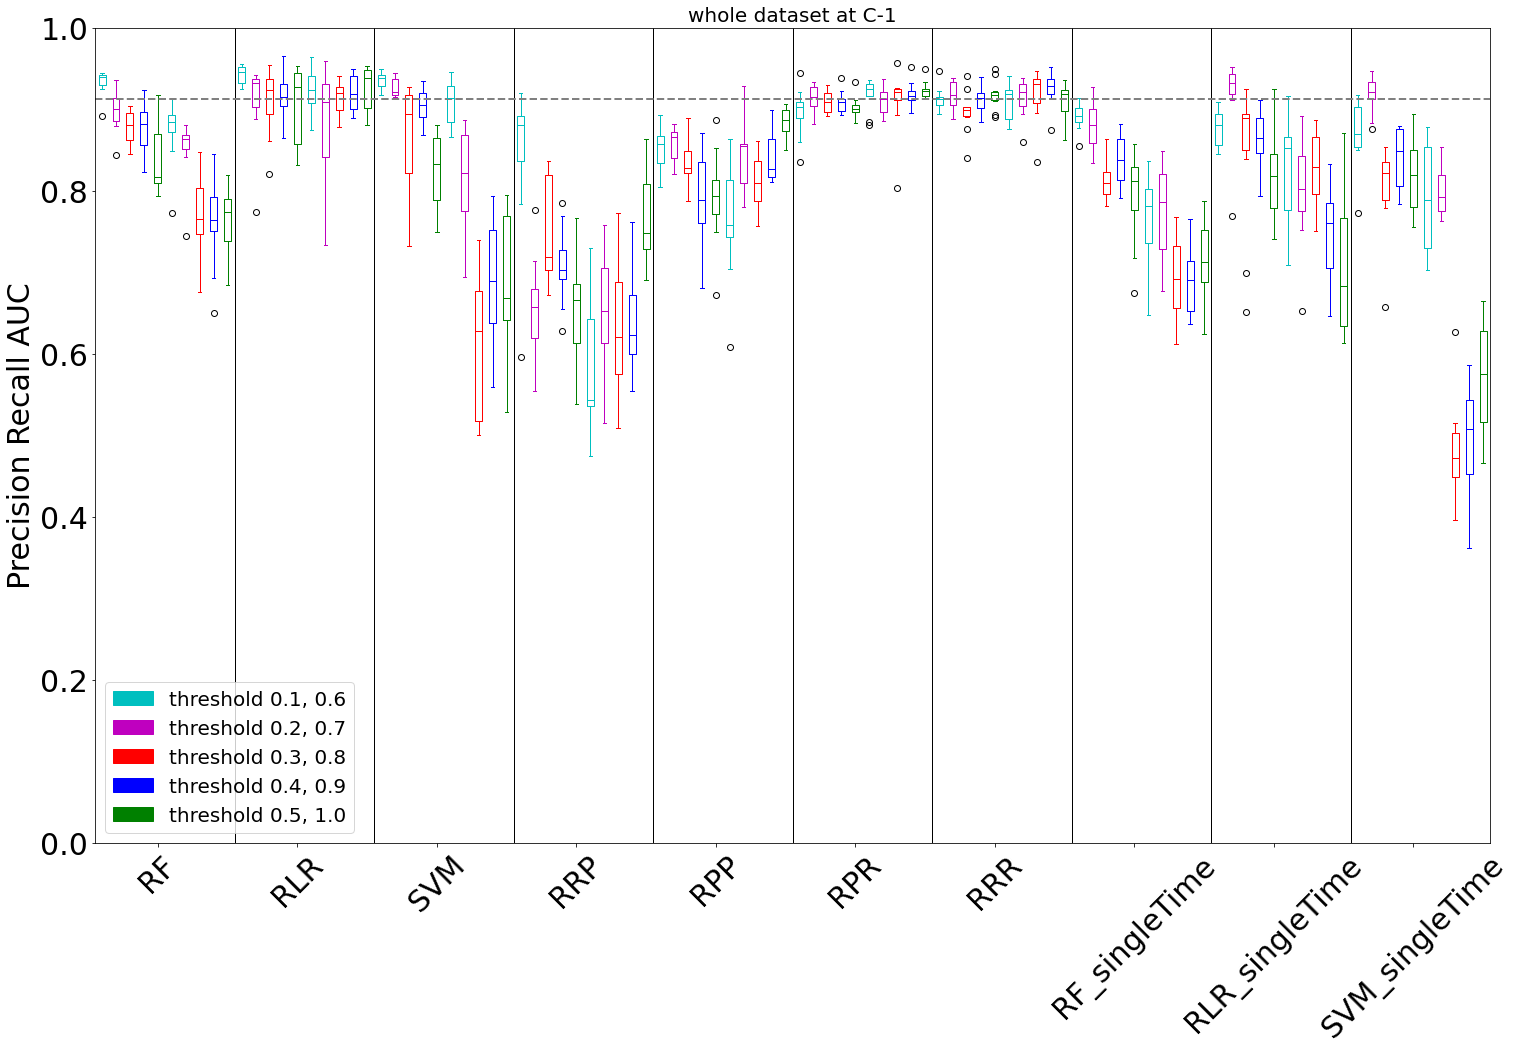

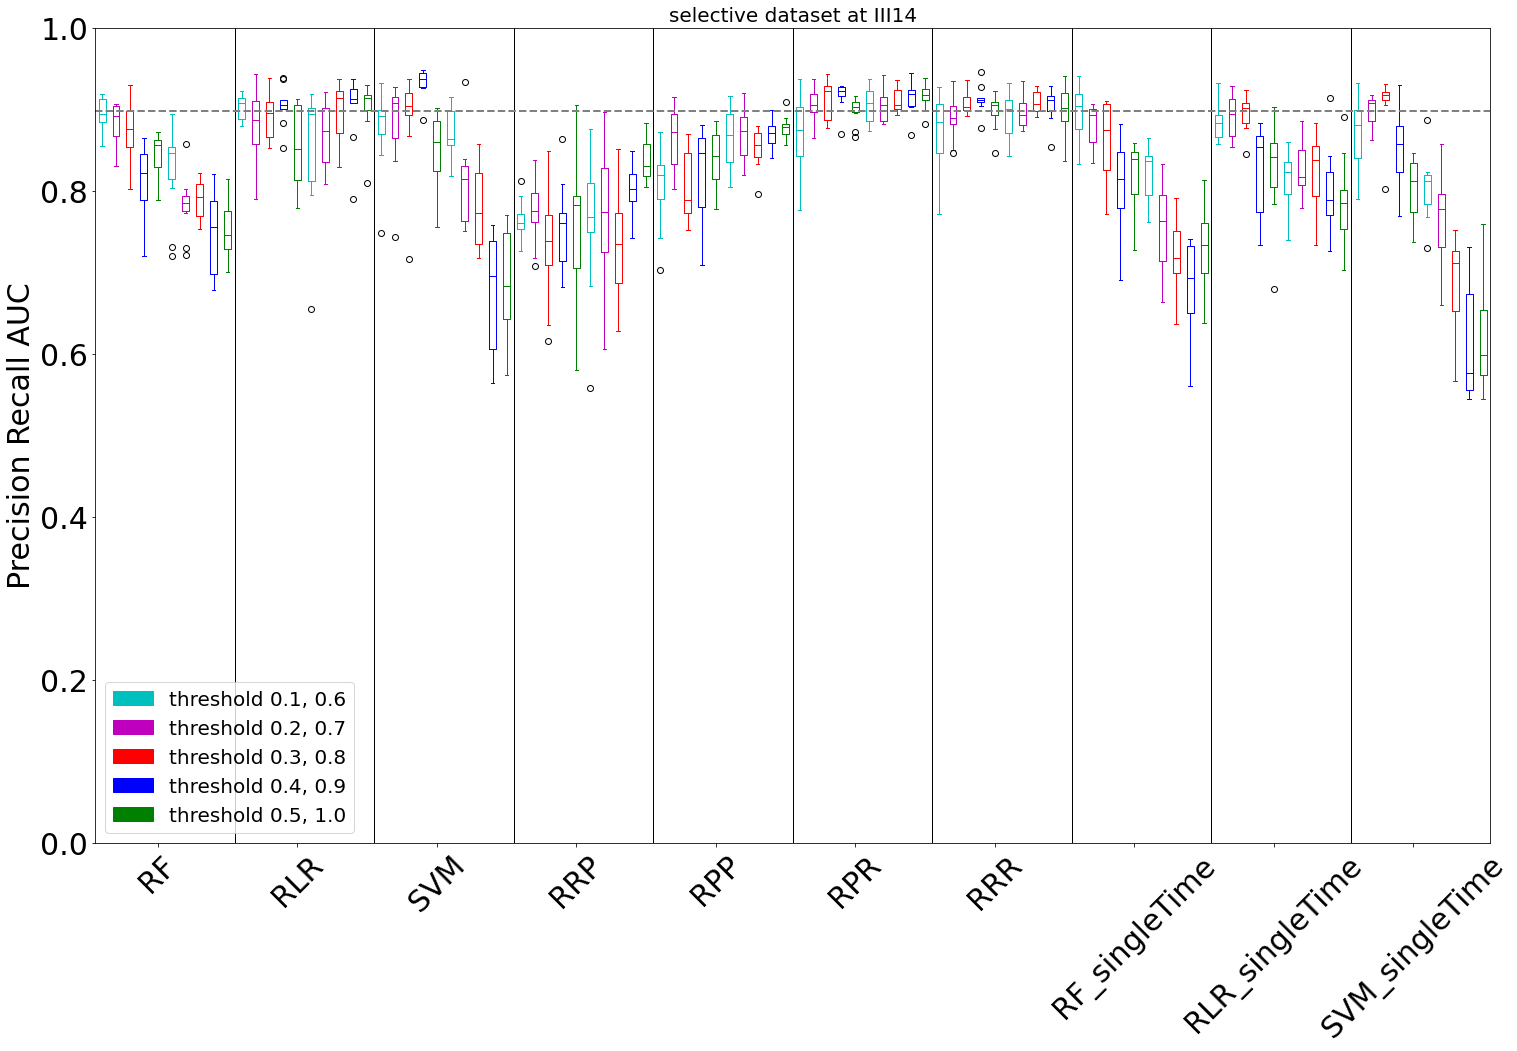

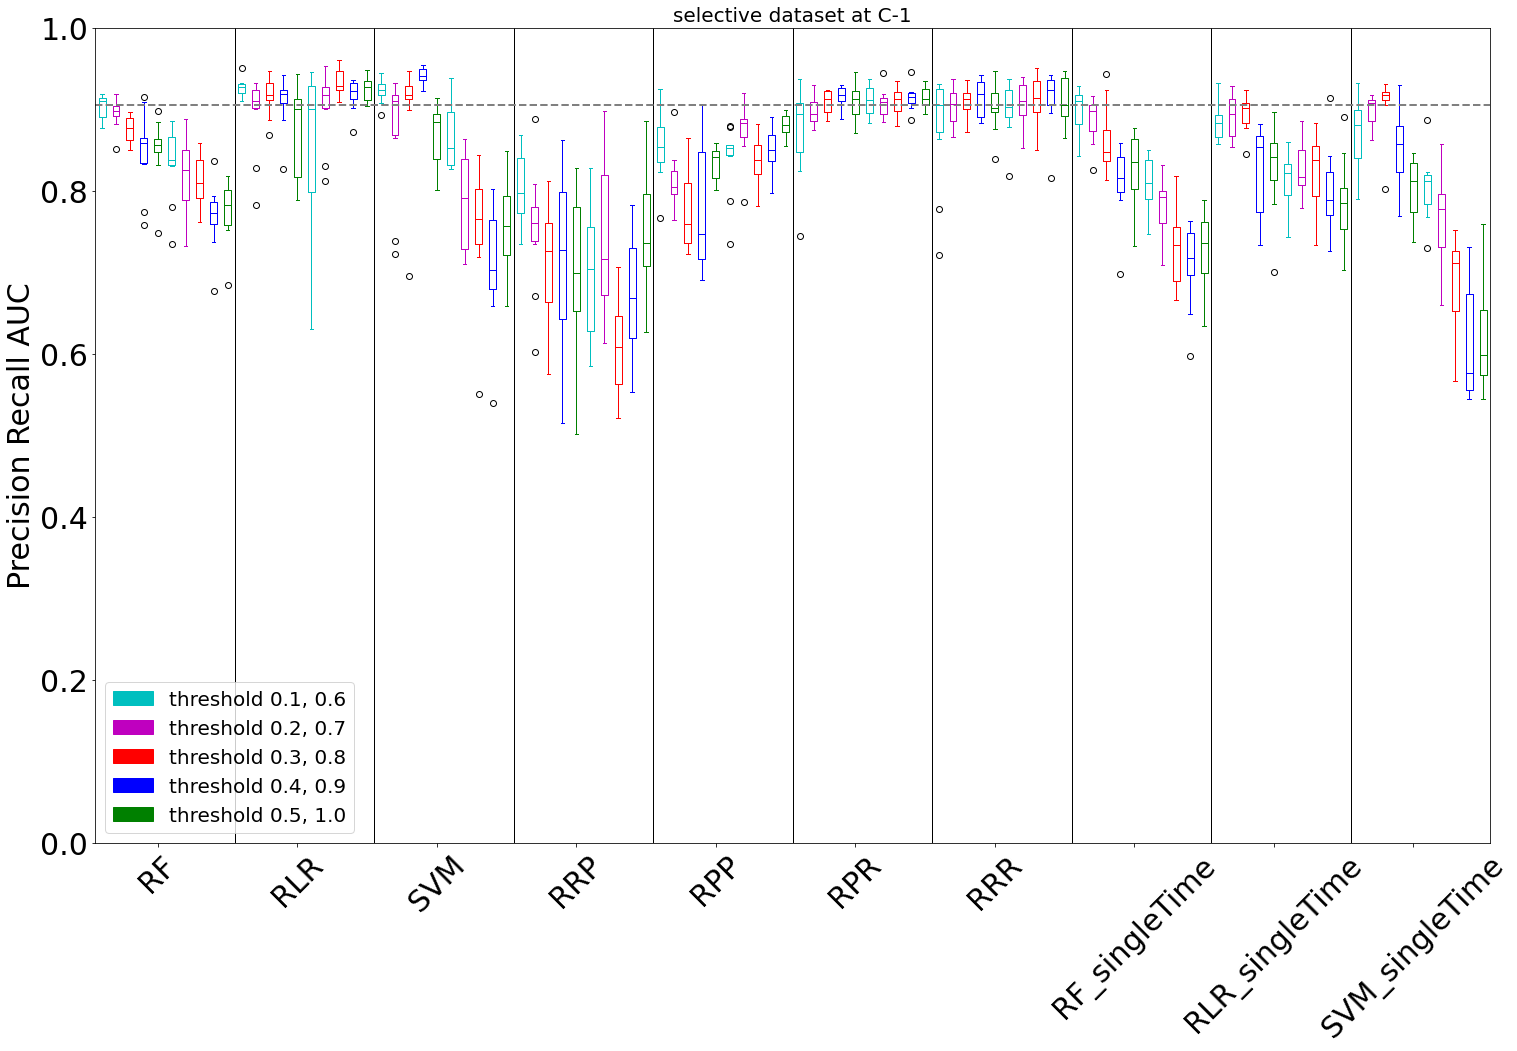

In [4]:
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'RF_singleTime', 'RLR_singleTime', 'SVM_singleTime']
colors = ['c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g']
results = calc_mean(results)
for dataset in ['whole', 'selective']:
    for time in times:
        plt.figure(figsize=(25, 15))
        for i, (t, c) in enumerate(zip(thresholds, colors)):
            results[dataset][f'{time}_ncv'].loc[t, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(rot=45, positions=range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)), notch=False, color=c, labels=[str(t) for x in range(0, len(columns))], grid=False)
        cpatch = mpatches.Patch(color='c', label='threshold 0.1, 0.6')
        mpatch = mpatches.Patch(color='m', label='threshold 0.2, 0.7')
        rpatch = mpatches.Patch(color='r', label='threshold 0.3, 0.8')
        bpatch = mpatches.Patch(color='b', label='threshold 0.4, 0.9')
        gpatch = mpatches.Patch(color='g', label='threshold 0.5, 1.0')
        for i in range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)):
            plt.vlines(i + 0.5, 0, 1, linewidth=1, color='k')
        plt.xticks(np.arange(int(len(thresholds) / 2), len(thresholds) * len(columns), len(thresholds)), fontsize = 30)
        plt.ylim((0.0, 1))
        plt.yticks(fontsize = 30)
        plt.axhline(y=results[dataset][f'{time}_ncv']['RRR'].loc['mean_thresholds'],linestyle='--',linewidth=2, color='gray')
        plt.legend(handles=[cpatch, mpatch, rpatch, bpatch, gpatch], fontsize = 20)
        plt.ylabel("Precision Recall AUC", fontsize = 30)
        plt.title(f"{dataset} dataset at {time}", fontsize = 20)
        plt.show()
        plt.close()

In [5]:
# Calc mean PR-AUC score for kernel combination "RPR" and "RRR" of the multitask SVM models

# print('mean_threshold at whole_III14 for RRR' + ' ' + str(results['whole']['III14_ncv']['RRR'].loc['mean_thresholds']))
# print('mean_threshold at whole_C-1 for RRR' + ' ' + str(results['whole']['C-1_ncv']['RRR'].loc['mean_thresholds']))
# print('mean_threshold at selective_III14 for RRR' + ' ' + str(results['selective']['III14_ncv']['RRR'].loc['mean_thresholds']))
# print('mean_threshold at selective_C-1 for RRR' + ' ' + str(results['selective']['C-1_ncv']['RRR'].loc['mean_thresholds']))
# print('\n')
# print('mean_threshold at whole_III14 for RPR' + ' ' + str(results['whole']['III14_ncv']['RPR'].loc['mean_thresholds']))
# print('mean_threshold at whole_C-1 for RPR' + ' ' + str(results['whole']['C-1_ncv']['RPR'].loc['mean_thresholds']))
# print('mean_threshold at selective_III14 for RPR' + ' ' + str(results['selective']['III14_ncv']['RPR'].loc['mean_thresholds']))
# print('mean_threshold at selective_C-1 for RPR' + ' ' + str(results['selective']['C-1_ncv']['RPR'].loc['mean_thresholds']))
# print('\n')
# print('mean_threshold at whole_III14 for RLR' + ' ' + str(results['whole']['III14_ncv']['RLR'].loc['mean_thresholds']))
# print('mean_threshold at whole_C-1 for RLR' + ' ' + str(results['whole']['C-1_ncv']['RLR'].loc['mean_thresholds']))
# print('mean_threshold at selective_III14 for RLR' + ' ' + str(results['selective']['III14_ncv']['RLR'].loc['mean_thresholds']))
# print('mean_threshold at selective_C-1 for RLR' + ' ' + str(results['selective']['C-1_ncv']['RLR'].loc['mean_thresholds']))

In [6]:
# Plot performance plots with the mean PR-AUC score of the kernel combination "RPR" as abline

# columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'RF_singleTime', 'RLR_singleTime', 'SVM_singleTime']
# colors = ['c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g']
# for dataset in ['whole', 'selective']:
#     for time in times:
#         plt.figure(figsize=(25, 15))
#         for i, (t, c) in enumerate(zip(thresholds, colors)):
#             results[dataset][f'{time}_ncv'].loc[t, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(rot=45, positions=range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)), notch=False, color=c, labels=[str(t) for x in range(0, len(columns))], grid=False)
#         cpatch = mpatches.Patch(color='c', label='threshold 0.1, 0.6')
#         mpatch = mpatches.Patch(color='m', label='threshold 0.2, 0.7')
#         rpatch = mpatches.Patch(color='r', label='threshold 0.3, 0.8')
#         bpatch = mpatches.Patch(color='b', label='threshold 0.4, 0.9')
#         gpatch = mpatches.Patch(color='g', label='threshold 0.5, 1.0')
#         for i in range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)):
#             plt.vlines(i + 0.5, 0, 1, linewidth=1, color='k')
#         plt.xticks(np.arange(int(len(thresholds) / 2), len(thresholds) * len(columns), len(thresholds)), fontsize = 30)
#         plt.ylim((0.0, 1))
#         plt.yticks(fontsize = 30)
#         plt.axhline(y=results[dataset][f'{time}_ncv']['RPR'].loc['mean_thresholds'],linestyle='--',linewidth=2, color='gray')
#         plt.legend(handles=[cpatch, mpatch, rpatch, bpatch, gpatch], fontsize = 20)
#         plt.ylabel("precision_recall", fontsize = 30)
#         plt.title(f"{dataset} dataset at {time}", fontsize = 20)
#         plt.show()
#         plt.close()